In [1]:
"""
Franke surface + language-shaped prior inside a Bayesian Optimization loop
===========================================================================

What this script does
---------------------
- Defines a 2D synthetic objective (Franke function) on [0,1]^2 to **maximize**.
- Uses your **language_shaped_prior_llm.py** helpers (Schema, PriorBuilder, etc.).
- Fits a **GP on residuals** (y - m0(x)), then wraps it with a deterministic prior mean m0(x)
  so the acquisition sees the **total posterior = m0(x) + GP_residual(x)**.
- Runs an **analytic EI** loop (q=1) and tracks best-so-far.
- Provides example readouts (flat, helpful, misleading) so you can compare how priors change performance.
- Jupyter-friendly: functions return pandas DataFrames; one-liner demo at bottom.

Usage (in Jupyter)
------------------
1) Ensure `language_shaped_prior_llm.py` is importable (we add '/mnt/data' to sys.path by default).
2) Run this cell/file; then run the demo cell at the very bottom (or call `compare_readouts(...)`).
3) Optional: call `plot_runs(history_df)` to visualize best-so-far.

Dependencies
------------
- torch >= 1.11, botorch, gpytorch, numpy, pandas, matplotlib

Notes
-----
- We use **analytic ExpectedImprovement** (EI) so we don't need fantasies.
- The wrapper model ensures EI evaluates improvement on the **total** posterior (m0 + residual GP),
  which is the principled way to use a shaped prior with BO.
"""

from __future__ import annotations
import sys, math, warnings
from dataclasses import dataclass
from typing import Dict, Any, List, Tuple, Optional

# --- Make sure your helper module is reachable ---
sys.path.append('/mnt/data')  # adjust if needed

import numpy as np
import pandas as pd

import torch
from torch import Tensor


a = torch.tensor(1.0)  # just to ensure torch is imported

# BoTorch / GPyTorch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.optim.optimize import optimize_acqf
from botorch.models.model import Model
from botorch.posteriors.gpytorch import GPyTorchPosterior
from botorch.utils.transforms import normalize
from botorch.utils.sampling import draw_sobol_samples

import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal

# Your prior helpers
from language_shaped_prior_llm import (
    Schema, ContinuousVar, CategoricalVar,
    PriorBuilder, HeuristicReadout
)



# ---- Device / dtype setup ----
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

# GPU is much faster in float32; switch from double unless you truly need fp64
DTYPE = torch.float32
torch.set_default_dtype(DTYPE)



def _ensure_prior_torch(prior: PriorBuilder, schema: Schema) -> PriorBuilder:
    """Attach a torch-native m0 evaluator to avoid CPU round-trips."""
    if hasattr(prior, "_has_torch_m0"):
        return prior

    def _sigmoid_torch(z: Tensor, k: float = 6.0) -> Tensor:
        return 1.0 / (1.0 + torch.exp(-k * (z - 0.5)))

    def _gauss_torch(z: Tensor, mu: float = 0.6, s: float = 0.18) -> Tensor:
        return torch.exp(-0.5 * ((z - mu) / (s + 1e-12)) ** 2)

    def _sat_torch(z: Tensor, a: float = 3.0) -> Tensor:
        return 1.0 - torch.exp(-a * torch.clamp(z, 0.0, 1.0))

    cont_vars = schema.continuous
    interactions = prior.readout.get("interactions") or []
    effects = prior.readout.get("effects") or {}

    def m0_torch(X: Tensor) -> Tensor:
        orig_shape = X.shape[:-1]
        X2 = X.reshape(-1, X.shape[-1]).to(dtype=DTYPE)
        device = X2.device
        contrib = torch.zeros(X2.shape[0], device=device, dtype=DTYPE)
        norm_cache = {}
        for idx, var in enumerate(cont_vars):
            low = float(var.low)
            high = float(var.high)
            span = high - low + 1e-12
            z = (X2[:, idx] - low) / span
            norm_cache[var.name] = z
            eff = (effects.get(var.name) or {})
            effect = eff.get("effect", "flat")
            scale = float(eff.get("scale", 0.0))
            confidence = float(eff.get("confidence", 0.0))
            range_hint = eff.get("range_hint", None)
            mu = 0.6
            if isinstance(range_hint, (list, tuple)) and len(range_hint) == 2:
                mu = 0.5 * (float(range_hint[0]) + float(range_hint[1]))
            amp = scale * (0.5 + 0.5 * confidence)
            if abs(amp) < 1e-12:
                continue
            if effect == "increase":
                contrib = contrib + amp * _sigmoid_torch(z)
            elif effect == "decrease":
                contrib = contrib - amp * _sigmoid_torch(z)
            elif effect == "increase-saturating":
                contrib = contrib + amp * _sat_torch(z)
            elif effect == "nonmonotone-peak":
                contrib = contrib + amp * _gauss_torch(z, mu=mu)
            elif effect == "nonmonotone-valley":
                contrib = contrib - amp * _gauss_torch(z, mu=mu)
        for it in interactions:
            pair = it.get("pair", [])
            if not isinstance(pair, (list, tuple)) or len(pair) != 2:
                continue
            if not all(name in norm_cache for name in pair):
                continue
            conf = float(it.get("confidence", 0.3))
            sign = 1.0 if it.get("type", "synergy") == "synergy" else -1.0
            contrib = contrib + 0.2 * conf * sign * (norm_cache[pair[0]] * norm_cache[pair[1]])
        return (100.0 * contrib).reshape(orig_shape)

    prior.m0_torch = m0_torch
    prior._has_torch_m0 = True
    return prior


# -------------------- Synthetic objective: Franke surface --------------------

def franke_function_np(xy: np.ndarray) -> np.ndarray:
    """Franke function on [0,1]^2. Accepts shape (N,2) numpy, returns shape (N,).
    We will **maximize** it (no sign flip). No noise here; add outside if needed.
    """
    x = xy[:, 0]
    y = xy[:, 1]
    term1 = 0.75 * np.exp(-(9*x - 2)**2 / 4.0 - (9*y - 2)**2 / 4.0)
    term2 = 0.75 * np.exp(-(9*x + 1)**2 / 49.0 - (9*y + 1)**2 / 10.0)
    term3 = 0.50 * np.exp(-(9*x - 7)**2 / 4.0 - (9*y - 3)**2 / 4.0)
    term4 = 0.20 * np.exp(-(9*x - 4)**2 - (9*y - 7)**2)
    return term1 + term2 + term3 - term4


def true_objective(X: Tensor, noise_sd: float = 0.0, rng: Optional[np.random.Generator] = None) -> Tensor:
    # X: (..., 2) in [0,1], already on DEVICE/DTYPE
    x = X[..., 0]
    y = X[..., 1]
    term1 = 0.75 * torch.exp(-(9*x - 2)**2 / 4.0 - (9*y - 2)**2 / 4.0)
    term2 = 0.75 * torch.exp(-(9*x + 1)**2 / 49.0 - (9*y + 1)**2 / 10.0)
    term3 = 0.50 * torch.exp(-(9*x - 7)**2 / 4.0 - (9*y - 3)**2 / 4.0)
    term4 = 0.20 * torch.exp(-(9*x - 4)**2 - (9*y - 7)**2)
    f = term1 + term2 + term3 - term4
    if noise_sd > 0.0:
        f = f + noise_sd * torch.randn_like(f)
    return f.unsqueeze(-1)


# ---------------- Language-shaped prior tooling (Schema + PriorBuilder) -------

def make_schema() -> Schema:
    # You can change roles to trigger different default heuristics in HeuristicReadout
    return Schema(
        continuous=[
            ContinuousVar(name="x1", low=0.0, high=1.0, role="temperature"),
            ContinuousVar(name="x2", low=0.0, high=1.0, role="concentration"),
        ],
        categorical=[],
    )


def make_readout_flat(schema: Schema) -> Dict[str, Any]:
    """A neutral prior (m0 = 0 everywhere)."""
    effects = {v.name: {"effect": "flat", "scale": 0.0, "confidence": 0.0} for v in schema.continuous}
    return {"effects": effects, "interactions": []}


def make_readout_helpful(schema: Schema) -> Dict[str, Any]:
    """Helpful prior roughly aligned with the Franke global maximum.
    Franke max ≈ (x1~0.21, x2~0.17). We give broad hints covering that zone.
    """
    effects = {
        "x1": {"effect": "nonmonotone-peak", "scale": 0.9, "confidence": 0.9, "range_hint": [0.10, 0.35]},
        "x2": {"effect": "nonmonotone-peak", "scale": 0.9, "confidence": 0.9, "range_hint": [0.10, 0.30]},
    }
    return {
        "effects": effects,
        "interactions": [
            {"pair": ["x1", "x2"], "type": "synergy", "confidence": 0.7}
        ],
    }


def make_readout_very_helpful(schema: Schema) -> Dict[str, Any]:
    """Very informative prior tightly focused near the Franke global maximum.
    Narrow range hints give a strong location cue.
    """
    effects = {
        "x1": {"effect": "nonmonotone-peak", "scale": 1.0, "confidence": 0.99, "range_hint": [0.17, 0.25]},
        "x2": {"effect": "nonmonotone-peak", "scale": 1.0, "confidence": 0.99, "range_hint": [0.13, 0.21]},
    }
    return {
        "effects": effects,
        "interactions": [
            {"pair": ["x1", "x2"], "type": "synergy", "confidence": 0.9}
        ],
    }



def make_readout_misleading(schema: Schema) -> Dict[str, Any]:
    """A misleading prior (e.g., says x1 decreases, x2 increases monotonically)."""
    effects = {
        "x1": {"effect": "decrease", "scale": 0.7, "confidence": 0.8},
        "x2": {"effect": "increase", "scale": 0.7, "confidence": 0.8},
    }
    return {"effects": effects, "interactions": []}


# ------------------ GP over residuals + deterministic mean wrapper ------------

class GPWithPriorMean(Model):
    """Wrap a residual GP with a deterministic prior mean m0(x) from PriorBuilder.

    The base GP is fit on residuals: y_resid = y - m0(x).
    The posterior returned by this wrapper is the total posterior of f(x) = m0(x) + g(x),
    where g ~ GP_residual. Covariance is unchanged.
    """
    def __init__(self, base_gp: SingleTaskGP, prior: PriorBuilder, schema: Schema, m0_scale: float = 1.0):
        super().__init__()
        self.base_gp = base_gp
        self.prior = prior
        self.schema = schema
        self.m0_scale = float(m0_scale)

    @property
    def num_outputs(self) -> int:
        return 1

    def _m0_from_X(self, X: Tensor) -> Tensor:
        d = X.shape[-1]
        X2 = X.reshape(-1, d)
        # Fast path: if prior exposes a torch method, use it
        if hasattr(self.prior, "m0_torch"):
            m0 = self.prior.m0_torch(X2).to(device=DEVICE, dtype=DTYPE)
            return (self.m0_scale * m0).reshape(X.shape[:-1])

        # Fallback to pandas/NumPy
        X_np = X2.detach().cpu().numpy()
        cols = [v.name for v in self.schema.continuous] + [c.name for c in self.schema.categorical]
        df = pd.DataFrame(X_np, columns=cols)
        m0_np = self.prior.m0_df(df)
        m0 = torch.as_tensor(m0_np, device=DEVICE, dtype=DTYPE).reshape(X.shape[:-1])
        return self.m0_scale * m0

    def posterior(self, X: Tensor, observation_noise: bool = False, **kwargs) -> GPyTorchPosterior:
        base_post = self.base_gp.posterior(X, observation_noise=observation_noise, **kwargs)
        mvn = base_post.mvn
        m0 = self._m0_from_X(X).reshape(mvn.mean.shape)
        new_mvn = MultivariateNormal(mean=mvn.mean + m0, covariance_matrix=mvn.covariance_matrix)
        return GPyTorchPosterior(new_mvn)

    # Delegate commonly-used utilities to base model (defensive completeness)
    def condition_on_observations(self, X: Tensor, Y: Tensor, noise: Optional[Tensor] = None, **kwargs):
        cm = self.base_gp.condition_on_observations(X=X, Y=Y, noise=noise, **kwargs)
        return GPWithPriorMean(base_gp=cm, prior=self.prior, schema=self.schema, m0_scale=self.m0_scale)

    def fantasize(self, X: Tensor, sampler, observation_noise: bool = True, **kwargs):
        fm = self.base_gp.fantasize(X=X, sampler=sampler, observation_noise=observation_noise, **kwargs)
        return GPWithPriorMean(base_gp=fm, prior=self.prior, schema=self.schema, m0_scale=self.m0_scale)

    def subset_output(self, idcs: List[int]) -> 'GPWithPriorMean':
        # Single output; just return self.
        return self


# ------------------------------ BO utilities ---------------------------------

def fit_residual_gp(X_obs: Tensor, y_obs: Tensor, prior: PriorBuilder, schema: Schema) -> Tuple[SingleTaskGP, Tensor, float]:
    """Fit SingleTaskGP on residuals y - alpha*m0(X) with a calibrated scale alpha.
    Returns (residual_gp, y_resid, alpha).
    X_obs: (N,2) in [0,1]; y_obs: (N,1)
    """
    # Compute raw m0 on the observed points
    m0_raw = prior.m0_torch(X_obs).reshape(-1)
    y_vec = y_obs.reshape(-1)

    # Calibrate a scale alpha so prior magnitude matches the data magnitude.
    # Use least-squares with intercept -> center both vectors.
    m0_c = m0_raw - m0_raw.mean()
    y_c = y_vec - y_vec.mean()
    denom = torch.dot(m0_c, m0_c).item()
    alpha = torch.dot(m0_c, y_c).item() / (denom + 1e-12) if denom > 0 else 0.0

    # Residuals
    m0_t = (alpha * m0_raw).unsqueeze(-1)
    y_resid = y_obs - m0_t

    gp = SingleTaskGP(train_X=X_obs, train_Y=y_resid).to(DEVICE)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp).to(DEVICE)
    fit_gpytorch_mll(mll)
    return gp, y_resid, alpha


def propose_next_point(model_total: Model, X_dim: int = 2, num_restarts: int = 10, raw_samples: int = 256) -> Tensor:
    bounds = torch.stack([torch.zeros(X_dim, device=DEVICE, dtype=DTYPE), torch.ones(X_dim, device=DEVICE, dtype=DTYPE)])
    # Use analytic EI (q=1)
    # best_f will be set when constructing EI by caller, since it depends on y_obs
    # Here we only optimize the acqf once constructed.
    def _optimize(acqf):
        cand, _ = optimize_acqf(
            acq_function=acqf,
            bounds=bounds,
            q=1,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
            options={"maxiter": 200, "batch_limit": 5},
        )
        return cand.squeeze(0)  # (2,)
    return _optimize


def bo_loop(
    readout: Dict[str, Any],
    n_init: int = 4,
    n_iter: int = 20,
    noise_sd: float = 0.0,
    seed: int = 0,
    prior_strength_pseudopts: float = 8.0,
    # Safety rail toggles
    sr1_calibrate_alpha: bool = True,
    sr2_alignment_gate: bool = False,
    sr3_mixture_with_flat: bool = False,
    sr4_anneal: bool = False,
    # Safety rail parameters
    sr2_threshold: float = 0.0,     # gate if rho <= threshold
    sr2_alpha_max: float = 5.0,     # cap magnitude after gate
    sr2_flip_on_negative: bool = False,
    sr3_w_max: float = 1.0,         # cap for mixture weight w(rho)
    sr4_boost: float = 1.0,
    sr4_decay: float = 1.0,
    verbose: bool = False,
) -> pd.DataFrame:
    """Run one BO loop with a given readout. Returns a history DataFrame with:
    iter, x1, x2, y, best_so_far, acq, readout_name
    """
    rng = np.random.default_rng(seed)
    torch.manual_seed(seed)
    if USE_CUDA: torch.cuda.manual_seed_all(seed)

    schema = make_schema()
    prior = PriorBuilder(schema=schema, readout=readout, prior_strength_pseudopts=prior_strength_pseudopts)
    prior = _ensure_prior_torch(prior, schema)

    # Initial design via Sobol
    X_init = draw_sobol_samples(bounds=torch.stack([torch.zeros(2,device=DEVICE, dtype=DTYPE), torch.ones(2,device=DEVICE, dtype=DTYPE)]), n= n_init, q=1, seed=seed).squeeze(1).to(DEVICE,DTYPE)
    y_init = true_objective(X_init, noise_sd=noise_sd, rng=rng)

    X_obs = X_init.clone()
    y_obs = y_init.clone()

    records: List[Dict[str, Any]] = []

    def _record(i: int, x: Tensor, y: Tensor, best: float):
        records.append({
            "iter": i,
            "x1": float(x[0].item()),
            "x2": float(x[1].item()),
            "y": float(y.item()),
            "best_so_far": float(best),
        })

    # Record initials
    best = float(y_obs.max().item())
    for i in range(X_obs.shape[0]):
        _record(i - X_obs.shape[0], X_obs[i], y_obs[i], best)

    # Optimization iterations
    for t in range(n_iter):
        # 1) fit residual GP on current data
        gp_resid, y_resid, alpha_ls = fit_residual_gp(X_obs, y_obs, prior, schema)
        alpha_eff = alpha_ls if sr1_calibrate_alpha else 1.0  # Rail 1

        # 1b) alignment on observed points
        rho = _alignment_on_obs(X_obs, y_obs, prior, schema)

        # 2) alignment gate (Rail 2)
        if sr2_alignment_gate:
            if rho <= sr2_threshold:
                if sr2_flip_on_negative:
                    alpha_eff = -abs(alpha_eff)
                else:
                    alpha_eff = 0.0
            alpha_eff = float(np.clip(alpha_eff, -sr2_alpha_max, sr2_alpha_max))

        # 3) mixture with flat via w(rho) (Rail 3)
        if sr3_mixture_with_flat:
            w = float(np.clip(max(0.0, rho), 0.0, sr3_w_max))
            alpha_eff *= w

        # 4) anneal influence (Rail 4)
        if sr4_anneal:
            alpha_eff *= (sr4_boost * (sr4_decay ** t))

        model_total = GPWithPriorMean(gp_resid, prior, schema, m0_scale=alpha_eff)

        # 2) build EI on total posterior
        best_f = float(y_obs.max().item())
        EI = ExpectedImprovement(model=model_total, best_f=best_f, maximize=True)

        # 3) optimize EI for next point
        
        bounds = torch.stack([torch.zeros(2, device=DEVICE, dtype=DTYPE),torch.ones(2,  device=DEVICE, dtype=DTYPE),])
        x_next, _ = optimize_acqf(
            acq_function=EI,
            bounds=bounds,
            q=1,
            num_restarts=20,
            raw_samples=1024,
            options={"maxiter": 200, "batch_limit": 5},
        )
        x_next = x_next.squeeze(0)

        # 4) evaluate objective
        y_next = true_objective(x_next.unsqueeze(0), noise_sd=noise_sd, rng=rng).squeeze(0)

        # 5) update
        X_obs = torch.cat([X_obs, x_next.unsqueeze(0)], dim=0)
        y_obs = torch.cat([y_obs, y_next.unsqueeze(0)], dim=0)
        best = max(best, float(y_next.item()))
        _record(t, x_next, y_next, best)

        if verbose and ((t+1) % 5 == 0 or t == n_iter - 1):
            print(f"Iter {t+1:02d}: y_next={y_next.item():.4f}, best={best:.4f}")

    hist = pd.DataFrame.from_records(records)
    return hist


def compare_readouts(
    readouts: Dict[str, Dict[str, Any]],
    n_init: int = 4,
    n_iter: int = 20,
    noise_sd: float = 0.0,
    seed: int = 0,
    prior_strength_pseudopts: float = 8.0,
    # Safety rails
    sr1_calibrate_alpha: bool = True,
    sr2_alignment_gate: bool = False,
    sr3_mixture_with_flat: bool = False,
    sr4_anneal: bool = False,
    # Params
    sr2_threshold: float = 0.0,
    sr2_alpha_max: float = 5.0,
    sr2_flip_on_negative: bool = False,
    sr3_w_max: float = 1.0,
    sr4_boost: float = 1.0,
    sr4_decay: float = 1.0,
) -> pd.DataFrame:
    """Run multiple readouts and concatenate history with a 'readout' column."""
    dfs = []
    for name, ro in readouts.items():
        df = bo_loop(
            readout=ro,
            n_init=n_init,
            n_iter=n_iter,
            noise_sd=noise_sd,
            seed=seed,
            prior_strength_pseudopts=prior_strength_pseudopts,
            sr1_calibrate_alpha=sr1_calibrate_alpha,
            sr2_alignment_gate=sr2_alignment_gate,
            sr3_mixture_with_flat=sr3_mixture_with_flat,
            sr4_anneal=sr4_anneal,
            sr2_threshold=sr2_threshold,
            sr2_alpha_max=sr2_alpha_max,
            sr2_flip_on_negative=sr2_flip_on_negative,
            sr3_w_max=sr3_w_max,
            sr4_boost=sr4_boost,
            sr4_decay=sr4_decay,
        )
        df["readout"] = name
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)


def benchmark_readouts(
    readouts: Dict[str, Dict[str, Any]],
    seeds: List[int],
    n_init: int = 4,
    n_iter: int = 20,
    noise_sd: float = 0.0,
    prior_strength_pseudopts: float = 8.0,
    # Safety rails
    sr1_calibrate_alpha: bool = True,
    sr2_alignment_gate: bool = False,
    sr3_mixture_with_flat: bool = False,
    sr4_anneal: bool = False,
    # Params
    sr2_threshold: float = 0.0,
    sr2_alpha_max: float = 5.0,
    sr2_flip_on_negative: bool = False,
    sr3_w_max: float = 1.0,
    sr4_boost: float = 1.0,
    sr4_decay: float = 1.0,
) -> pd.DataFrame:
    dfs = []
    for s in seeds:
        df = compare_readouts(
            readouts,
            n_init=n_init,
            n_iter=n_iter,
            noise_sd=noise_sd,
            seed=s,
            prior_strength_pseudopts=prior_strength_pseudopts,
            sr1_calibrate_alpha=sr1_calibrate_alpha,
            sr2_alignment_gate=sr2_alignment_gate,
            sr3_mixture_with_flat=sr3_mixture_with_flat,
            sr4_anneal=sr4_anneal,
            sr2_threshold=sr2_threshold,
            sr2_alpha_max=sr2_alpha_max,
            sr2_flip_on_negative=sr2_flip_on_negative,
            sr3_w_max=sr3_w_max,
            sr4_boost=sr4_boost,
            sr4_decay=sr4_decay,
        )
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)


# ------------------------------ Plotting -------------------------------------

def _alignment_on_obs(X_obs: Tensor, y_obs: Tensor, prior: PriorBuilder, schema: Schema) -> float:
    """Pearson alignment between prior m0(X_obs) and observed y_obs.
    Returns rho in [-1,1]. Uses centered vectors to account for intercept.
    """
    m0 = prior.m0_torch(X_obs).reshape(-1)
    y_vec = y_obs.reshape(-1)
    m0c = m0 - m0.mean()
    yc = y_vec - y_vec.mean()
    num = torch.dot(m0c, yc).item()
    den = torch.sqrt(torch.dot(m0c, m0c) * torch.dot(yc, yc) + 1e-12).item()
    return num / den if den > 0 else 0.0


# --------- Diagnostics: prior alignment vs true function (Pearson/Spearman) --
def prior_alignment_scores(schema: Schema, readout: Dict[str, Any], n_grid: int = 5000, seed: int = 0) -> Dict[str, float]:
    """Compute correlation between prior mean m0(x) and true Franke f(x) on a random grid.
    Returns dict with pearson, spearman, and linear-scale alpha estimate.
    """
    rng = np.random.default_rng(seed)
    X = rng.random((n_grid, 2))  # in [0,1]^2
    df = pd.DataFrame(X, columns=[v.name for v in schema.continuous])

    prior = PriorBuilder(schema=schema, readout=readout)
    m0 = prior.m0_df(df)
    f = franke_function_np(X)

    # Center for LS alpha
    m0c = m0 - m0.mean()
    fc = f - f.mean()
    denom = float(np.dot(m0c, m0c) + 1e-12)
    alpha = float(np.dot(m0c, fc) / denom) if denom > 0 else 0.0

    # Pearson
    cov = float(np.dot(m0c, fc) / (len(m0) - 1))
    std_m0 = float(np.sqrt(np.dot(m0c, m0c) / (len(m0) - 1)))
    std_f = float(np.sqrt(np.dot(fc, fc) / (len(f) - 1)))
    pear = cov / (std_m0 * std_f + 1e-12)

    # Spearman (rank correlation)
    m0_ranks = np.argsort(np.argsort(m0))
    f_ranks = np.argsort(np.argsort(f))
    m0r_c = m0_ranks - m0_ranks.mean()
    fr_c = f_ranks - f_ranks.mean()
    cov_r = float(np.dot(m0r_c, fr_c) / (len(m0) - 1))
    std_m0r = float(np.sqrt(np.dot(m0r_c, m0r_c) / (len(m0) - 1)))
    std_fr = float(np.sqrt(np.dot(fr_c, fr_c) / (len(f) - 1)))
    spear = cov_r / (std_m0r * std_fr + 1e-12)

    return {"pearson": float(pear), "spearman": float(spear), "alpha_ls": alpha}


def estimate_franke_max(grid_n: int = 201) -> float:
    xs = np.linspace(0,1,grid_n)
    yy, xx = np.meshgrid(xs, xs)
    pts = np.c_[xx.ravel(), yy.ravel()]
    vals = franke_function_np(pts)
    return float(vals.max())


def aggregate_by_seed(history_df: pd.DataFrame) -> pd.DataFrame:
    # assumes columns: iter, best_so_far, readout, seed (we will add seed)
    return (history_df
            .groupby(["readout", "iter"], as_index=False)
            .agg(mean_best=("best_so_far", "mean"), std_best=("best_so_far", "std")))


def plot_runs(history_df: pd.DataFrame):
    import matplotlib.pyplot as plt
    plt.figure()
    for name, grp in history_df.groupby("readout"):
        g = grp.copy()
        g = g[g["iter"] >= 0]
        plt.plot(g["iter"].values, g["best_so_far"].values, label=name)
    plt.xlabel("Iteration")
    plt.ylabel("Best so far (Franke)")
    plt.title("Bayesian Optimization with Language-Shaped Priors (EI)")
    plt.legend()
    plt.show()


def plot_runs_mean(history_df: pd.DataFrame):
    import matplotlib.pyplot as plt
    agg = aggregate_by_seed(history_df)
    plt.figure()
    for name, grp in agg.groupby("readout"):
        g = grp.copy()
        g = g[g["iter"] >= 0]
        plt.plot(g["iter"].values, g["mean_best"].values, label=name)
        if not g["std_best"].isna().all():
            lo = g["mean_best"].values - g["std_best"].values
            hi = g["mean_best"].values + g["std_best"].values
            plt.fill_between(g["iter"].values, lo, hi, alpha=0.2)
    plt.xlabel("Iteration")
    plt.ylabel("Best so far (mean ± sd)")
    plt.title("BO with Priors — averaged over seeds")
    plt.legend()
    plt.show()


def plot_prior_map(schema: Schema, readout: Dict[str, Any], grid_n: int = 101):
    """Visualize the prior mean m0(x) over [0,1]^2."""
    import matplotlib.pyplot as plt
    xs = np.linspace(0, 1, grid_n)
    xx, yy = np.meshgrid(xs, xs)
    df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[v.name for v in schema.continuous])
    prior = PriorBuilder(schema=schema, readout=readout)
    m0 = prior.m0_df(df).reshape(grid_n, grid_n)
    plt.figure()
    cs = plt.contourf(xx, yy, m0, levels=20)
    plt.colorbar(cs)
    plt.title("Prior mean m0(x)")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.show()



# ------------------------------- LLM readout module ---------------------------
LLM_READOUT_SYSTEM_PROMPT = (
"You are a chemistry-aware optimization assistant. "
"Given a description of a 2D response surface with variables 'x1' and 'x2' (both in [0,1]), "
"you will output a *structured readout* that qualitatively encodes trends as a prior for Bayesian Optimization. "
"Return STRICT JSON with keys: 'effects' (per-variable) and 'interactions' (list)."
"For each variable, produce: {effect: one of ['increase','decrease','nonmonotone-peak','u-shape','flat'], "
"scale: 0..1 (how strong), confidence: 0..1, optional range_hint: [low, high] inside [0,1]}."
"For interactions, produce objects like {pair:['x1','x2'], type: one of ['synergy','antagonism'], confidence:0..1}."
"Prefer broad, safe hints over overly precise claims; keep values inside bounds."
)




def _llm_messages_for_description(description: str, schema: Schema) -> list:
    # Embed schema roles/bounds as context so LLM stays consistent.
    var_ctx = []
    for v in schema.continuous:
        var_ctx.append({"name": v.name, "low": v.low, "high": v.high, "role": getattr(v, "role", None)})
    sys_ctx = json.dumps({"variables": var_ctx}, ensure_ascii=False)
    return [{"role": "system", "content": LLM_READOUT_SYSTEM_PROMPT}, {"role": "user", "content": f"Schema: {sys_ctx} Description: {description} Return JSON only."},]






def sanitize_readout(readout: Dict[str, Any], schema: Schema) -> Dict[str, Any]:
    # Clamp and ensure keys exist; fallback to flat if invalid.
    try:
        effects = readout.get("effects", {})
        inter = readout.get("interactions", [])
        # ensure all variables present
        for v in schema.continuous:
            if v.name not in effects:
                effects[v.name] = {"effect": "flat", "scale": 0.0, "confidence": 0.0}
            e = effects[v.name]
            e["effect"] = e.get("effect", "flat")
            e["scale"] = float(np.clip(e.get("scale", 0.0), 0.0, 1.0))
            e["confidence"] = float(np.clip(e.get("confidence", 0.0), 0.0, 1.0))
            if "range_hint" in e and isinstance(e["range_hint"], (list, tuple)) and len(e["range_hint"]) == 2:
                lo = float(np.clip(e["range_hint"][0], 0.0, 1.0))
                hi = float(np.clip(e["range_hint"][1], 0.0, 1.0))
                if hi < lo:
                    lo, hi = hi, lo
                e["range_hint"] = [lo, hi]
            else:
                e.pop("range_hint", None)
        # interactions sanity
        inter2 = []
        for it in inter:
            if not isinstance(it, dict):
                continue
            pair = it.get("pair", [])
            if pair == ["x1", "x2"] or pair == ["x2", "x1"]:
                inter2.append({
                    "pair": ["x1", "x2"],
                    "type": it.get("type", "synergy"),
                    "confidence": float(np.clip(it.get("confidence", 0.0), 0.0, 1.0)),
                })
        return {"effects": effects, "interactions": inter2}
    except Exception:
        # Fallback flat
        return make_readout_flat(schema)


def llm_generate_readout(description: str, schema: Schema, model: str = "gpt-4o-mini", temperature: float = 0.2) -> Dict[str, Any]:
    """Call OpenAI to turn a text description into a structured readout.
    Requires OPENAI_API_KEY to be set and `pip install openai` (>=1.0).
    
    """
    import httpx


    try:
        from openai import OpenAI
    except Exception as e:
        raise RuntimeError("Please `pip install openai` (>=1.0).") from e

    import json

    client = OpenAI(http_client=httpx.Client(verify=False))
    messages = _llm_messages_for_description(description, schema)

    # Prefer Chat Completions with JSON mode for wide compatibility
    try:
        resp = client.chat.completions.create(
            model=model,
            temperature=temperature,
            response_format={"type": "json_object"},
            messages=messages,
        )
        content = resp.choices[0].message.content
        data = json.loads(content)
    except Exception as e:
        # Fallback: try Responses API if available
        try:
            resp = client.responses.create(
                model=model,
                input=messages,
                temperature=temperature,
                extra_headers={"OpenAI-Beta": "assistants=v2"},
            )
            # best-effort extraction
            content = resp.output_text
            data = json.loads(content)
        except Exception as e2:
            raise RuntimeError(f"LLM call failed: {e} Fallback also failed: {e2}")

    return sanitize_readout(data, schema)



/home/amirreza/anaconda3/envs/pol_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
schema = make_schema()

bullet_context = """
Task: Describe the response of a 2D system with variables x1,x2 in [0,1].
Trends:
- Overall high performance occurs when x1 is on the lower side (roughly low-to-mid), and x2 is in the low range.
- Very high x1 tends to degrade the response (over-processing).
- x2 shows a nonmonotone behavior: very low x2 can be weak, mid-low is best, and very high x2 declines.
- There is mild positive synergy between x1 and x2 near low x2.
Constraints:
- Keep any numeric hints inside [0,1]; prefer broad ranges over point estimates.
- Return JSON only, per schema.
"""

readout_llm = llm_generate_readout(bullet_context, schema, model="gpt-4o-mini", temperature=0.2)

In [3]:
readout_llm

{'effects': {'x1': {'effect': 'decrease',
   'scale': 0.7,
   'confidence': 0.8,
   'range_hint': [0.0, 0.5]},
  'x2': {'effect': 'nonmonotone-peak',
   'scale': 0.6,
   'confidence': 0.75,
   'range_hint': [0.0, 0.7]}},
 'interactions': [{'pair': ['x1', 'x2'],
   'type': 'synergy',
   'confidence': 0.6}]}

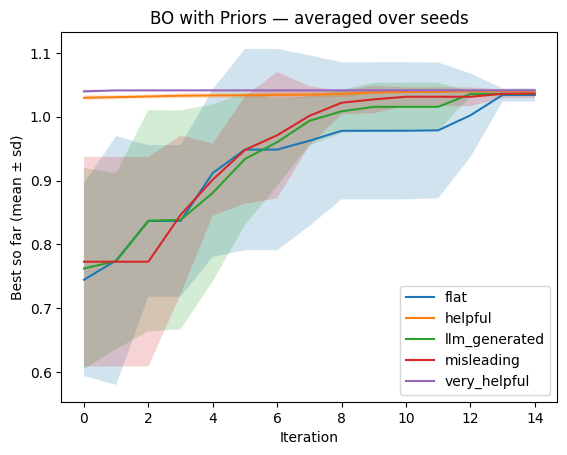

In [4]:
import warnings
warnings.filterwarnings('ignore')

schema = make_schema()
ros = {
    "flat": make_readout_flat(schema),
    "helpful": make_readout_helpful(schema),
    "very_helpful": make_readout_very_helpful(schema),
    "misleading": make_readout_misleading(schema),
    "llm_generated":readout_llm
}

# Baseline (same as before): sr1 on, others off
# df0 = benchmark_readouts(ros, seeds=list(range(10)), n_init=3, n_iter=15)

# All rails on
df1 = benchmark_readouts(
    ros, seeds=list(range(3)), n_init=3, n_iter=15,
    sr1_calibrate_alpha=True,
    sr2_alignment_gate=True,  sr2_threshold=0.0, sr2_alpha_max=3.0, sr2_flip_on_negative=False,
    sr3_mixture_with_flat=True, sr3_w_max=1.0,
    sr4_anneal=True, sr4_boost=2.0, sr4_decay=0.98
)

# plot_runs_mean(df0)
plot_runs_mean(df1)

In [11]:
print("CUDA available:", USE_CUDA, "device:", DEVICE, "dtype:", DTYPE)

CUDA available: True device: cuda dtype: torch.float32


In [26]:
import ray

import warnings
warnings.filterwarnings('ignore')

schema = make_schema()
ros = {
    "flat": make_readout_flat(schema),
    "helpful": make_readout_helpful(schema),
    "very_helpful": make_readout_very_helpful(schema),
    "misleading": make_readout_misleading(schema),
    "llm_generated":readout_llm
}



ray.init(num_gpus=1)  # Adjust for your setup

@ray.remote(num_gpus=0.1)

def run_screening(seed):
    return benchmark_readouts(
    ros, seeds=[seed], n_init=3, n_iter=15,
    sr1_calibrate_alpha=True,
    sr2_alignment_gate=True,  sr2_threshold=0.0, sr2_alpha_max=3.0, sr2_flip_on_negative=False,
    sr3_mixture_with_flat=True, sr3_w_max=1.0,
    sr4_anneal=True, sr4_boost=2.0, sr4_decay=0.98
)

futures = [run_screening.remote(seed) for seed in list(range(8))]
results = ray.get(futures)  # Combine all results as needed
    


2025-09-29 10:02:58,676	INFO worker.py:1951 -- Started a local Ray instance.
(run_screening pid=100340) /tmp/ipykernel_94696/268225776.py:251: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
(run_screening pid=100344) /home/amir/anaconda3/envs/pol_env/lib/python3.13/site-packages/botorch/acquisition/analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace
(run_screening pid=100344) 
(run_screening pid=100344) 	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 
(run_screening pid=100344) 
(run_screening pid=100344) instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
(run_screening pid=100344)   legacy_ei_

KeyboardInterrupt: 

(run_screening pid=100336) /home/amir/anaconda3/envs/pol_env/lib/python3.13/site-packages/botorch/optim/optimize.py:753: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
(run_screening pid=100336)   return _optimize_acqf_batch(opt_inputs=opt_inputs)
(run_screening pid=100336) /tmp/ipykernel_94696/268225776.py:251: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
(run_screening pid=100342) /home/amir/anaconda3/envs/pol_env/lib/python3.13/site-packages/botorch/acquisition/analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace
(run_screening pid=100342) 
(run_screening pid=100342) 	 ExpectedImprovement 	

In [27]:
ray.shutdown()

(run_screening pid=100344) /home/amir/anaconda3/envs/pol_env/lib/python3.13/site-packages/botorch/optim/optimize.py:753: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions. [repeated 2x across cluster]
(run_screening pid=100342)   return _optimize_acqf_batch(opt_inputs=opt_inputs) [repeated 8x across cluster]
(run_screening pid=100344) /tmp/ipykernel_94696/268225776.py:251: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444 [repeated 2x across cluster]
(run_screening pid=100344) /home/amir/anaconda3/envs/pol_env/lib/python3.13/site-packages/botorch/acquisition/analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply